# Mean/Covariance of a data set and effect of a linear transformation

We are going to investigate how the mean and (co)variance of a dataset changes
when we apply affine transformation to the dataset.

## Learning objectives
1. Get Farmiliar with basic programming using Python and Numpy/Scipy.
2. Learn to appreciate implementing
   functions to compute statistics of dataset in vectorized way.
3. Understand the effects of affine transformations on a dataset.
4. Understand the importance of testing in programming for machine learning.

First, let's import the packages that we will use for the week

In [3]:
# PACKAGE: DO NOT EDIT THIS CELL
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.style.use('fivethirtyeight')
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces
import time
import timeit

In [4]:
%matplotlib inline
from ipywidgets import interact

Next, we are going to retrieve Olivetti faces dataset.

When working with some datasets, before digging into further analysis, it is almost always
useful to do a few things to understand your dataset. First of all, answer the following
set of questions:

1. What is the size of your dataset?
2. What is the dimensionality of your data?

The dataset we have are usually stored as 2D matrices, then it would be really important
to know which dimension represents the dimension of the dataset, and which represents
the data points in the dataset. 

__When you implement the functions for your assignment, make sure you read
the docstring for what each dimension of your inputs represents the data points, and which 
represents the dimensions of the dataset!__.

In [8]:
image_shape = (64, 64)
# Load faces data
dataset = fetch_olivetti_faces()
faces = dataset.data.T

print('Shape of the faces dataset: {}'.format(faces.shape))
print('{} data points'.format(faces.shape[1]))

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\user\scikit_learn_data
Shape of the faces dataset: (4096, 400)
400 data points


When your dataset are images, it's a really good idea to see what they look like.

One very
convenient tool in Jupyter is the `interact` widget, which we use to visualize the images (faces). For more information on how to use interact, have a look at the documentation [here](http://ipywidgets.readthedocs.io/en/stable/examples/Using%20Interact.html).

We have created two function which help you visuzlie the faces dataset. You do not need to modify them.

In [9]:
def show_face(face):
    plt.figure()
    plt.imshow(face.reshape((64, 64)), cmap='gray')
    plt.show()

In [10]:
@interact(n=(0, faces.shape[1]-1))
def display_faces(n=0):
    plt.figure()
    plt.imshow(faces[:,n].reshape((64, 64)), cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=0, description='n', max=399), Output()), _dom_classes=('widget-interact'…

## 1. Mean and Covariance of a Dataset

In this week, you will need to implement functions in the cell below which compute the mean and covariance of a dataset.

# $ \overline{x}_{n+1} = \frac{ n \overline{x}_n + x }{n + 1} $
# $ \frac{1}{N} * \sum (x_i - m)(x_i - m)^T $

In [82]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE
def mean_naive(X):
    "Compute the mean for a dataset X nby iterating over the data points"
    # X is of size (D,N) where D is the dimensionality and N the number of data points
    D, N = X.shape
    mean = np.zeros((D,1))
    for n in range(N): # iterate over the dataset
        mean = (n * mean + X[:,n].reshape(D, 1)) / (n + 1) # <-- EDIT THIS
    return mean.reshape(D)

def cov_naive(X):
    """Compute the covariance for a dataset of size (D,N) 
    where D is the dimension and N is the number of data points"""
    # 1/N * \sum (x_i - m)(x_i - m)^T (where m is the mean)
    D, N = X.shape
    m = mean(X).reshape(D, 1)
    covariance = np.zeros((D, D))
    for n in range(N):
        covariance += (X[:,n].reshape(D, 1) - m) @ (X[:,n].reshape(D, 1) - m).T # <-- EDIT THIS 
    covariance /= N
    return covariance


def mean(X):
    "Compute the mean for a dataset of size (D,N) where D is the dimension and N is the number of data points"
    # given a dataset of size (D, N), the mean should be an array of size (D,)
    mean = np.mean(X, axis=1) # <-- EDIT THIS
    return mean

def cov(X):
    "Compute the covariance for a dataset"
    # X is of size (D,N)
    # https://stackoverflow.com/questions/16062804/numpy-cov-covariance-function-what-exactly-does-it-compute
    # It is possible to vectorize our code for computing the covariance, i.e., we do not need to explicitly
    # iterate over the entire dataset as looping in Python tends to be slow
    # We challenge you to give a vectorized implementation without using np.cov.
    D, N = X.shape
    m = mean(X).reshape(D, 1)
    
    covariance_matrix = (X - m) @ (X - m).T
    covariance_matrix /= N# <-- EDIT THIS
    return covariance_matrix

Now, let's see whether our implementations are consistent

In [83]:
np.testing.assert_almost_equal(mean(faces), mean_naive(faces), decimal=6)
np.testing.assert_almost_equal(cov(faces), cov_naive(faces))

With the `mean` function implemented, let's take a look at the _mean_ face of our dataset!

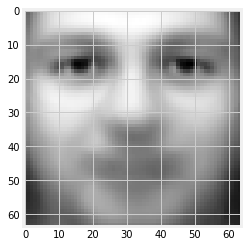

In [84]:
def mean_face(faces):
    return faces.mean(axis=1).reshape((64, 64))

plt.imshow(mean_face(faces), cmap='gray');

We can also visualize the covariance. Since the faces dataset are too high dimensional, let's instead take a look at the covariance matrix for a smaller dataset: the MNIST digits dataset.

One of the advantage of writing vectorized code is speedup gained when working on larger dataset. Loops in Python
are slow, and most of the time you want to utilise the fast native code provided by Numpy without explicitly using
for loops. To put things into perspective, we can benchmark the two different implementation with the `%time` function
in the following way:

In [85]:
# We have some HUUUGE data matrix which we want to compute its mean
X = np.random.randn(20, 1000)
# Benchmarking time for computing mean
%time mean_naive(X)
%time mean(X)
pass

Wall time: 18 ms
Wall time: 0 ns


In [88]:
# Benchmarking time for computing covariance
%time cov_naive(X)
%time cov(X)
pass

Wall time: 9 ms
Wall time: 0 ns


Alternatively, we can also see how running time increases as we increase the size of our dataset.
In the following cell, we run `mean`, `mean_naive` and `cov`, `cov_naive` for many times on different sizes of
the dataset and collect their running time. If you are less familiar with Python, you may want to spend
some time understanding what the code does.

The next cell includes a function that records the time taken for executing a function `f` by repeating it for `repeat` number of times. You do not need to modify the function but you can use it to compare the running time for functions which you are interested in knowing the running time.

In [90]:
def time(f, repeat=10):
    """Helper function to compute the time taken for running a function f
    """
    # you don't need to edit this function
    times = []
    for _ in range(repeat):
        start = timeit.default_timer()
        f()
        stop = timeit.default_timer()
        times.append(stop-start)
    return np.mean(times), np.std(times)

Let's first benchmark the running time for `mean` and `mean_naive`.

Note that it may take a long time for the code to run if you repeat it for too many times. If you do not see the next cell terminate within a reasonable amount of time, try reducing the number of times you `repeat` running the function.

In [91]:
fast_time = []
slow_time = []

# we iterate over datasets of different sizes, and compute the time taken to run mean, mean_naive on the dataset
for size in np.arange(100, 501, step=100):
    X = np.random.randn(size, 20)
    f = lambda : mean(X)  # we create an "anonymous" function for running mean on dataset X
    mu, sigma = time(f, repeat=10)   # the `time` function computes the mean and standard deviation of running
    fast_time.append((size, mu, sigma)) # keep the results of the runtime in a list
    
    # we repeat the same steps for `mean_naive`
    f = lambda : mean_naive(X)
    mu, sigma = time(f, repeat=10)
    slow_time.append((size, mu, sigma))

fast_time = np.array(fast_time)
slow_time = np.array(slow_time)

Let's visualize the running time for `mean` and `mean_naive`.

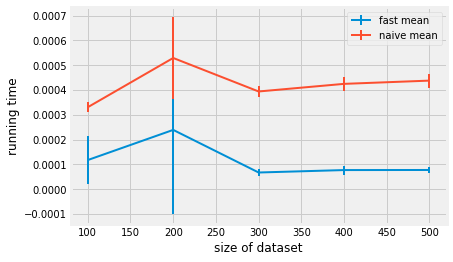

In [92]:
fig, ax = plt.subplots()
ax.errorbar(fast_time[:,0], fast_time[:,1], fast_time[:,2], label='fast mean', linewidth=2)
ax.errorbar(slow_time[:,0], slow_time[:,1], slow_time[:,2], label='naive mean', linewidth=2)
ax.set_xlabel('size of dataset')
ax.set_ylabel('running time')
plt.legend();

We can create a similar benchmark for `cov` and `cov_naive`. Follow the pattern for how we created the benchmark for `mean` and `mean_naive` and update the code below.

In [93]:
fast_time_cov = []
slow_time_cov = []

for size in np.arange(100, 501, step=100):
    X = np.random.randn(size, 20)
    # You should follow how we create the running time benchmarks for mean and mean_naive above to
    # create some benchmarks for the running time of cov_naive and cov
    f = lambda: cov(X)               # <-- EDIT THIS
    mu, sigma = time(f, repeat=10) # <-- EDIT THIS
    fast_time_cov.append((size, mu, sigma))
    
    f = lambda: cov_naive(X)         # <-- EDIT THIS
    mu, sigma = time(f, repeat=10) # <-- EDIT THIS
    slow_time_cov.append((size, mu, sigma))

fast_time_cov = np.array(fast_time_cov)
slow_time_cov = np.array(slow_time_cov)

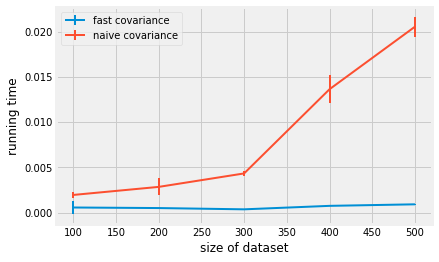

In [94]:
fig, ax = plt.subplots()
ax.errorbar(fast_time_cov[:,0], fast_time_cov[:,1], fast_time_cov[:,2], label='fast covariance', linewidth=2)
ax.errorbar(slow_time_cov[:,0], slow_time_cov[:,1], slow_time_cov[:,2], label='naive covariance', linewidth=2)
ax.set_xlabel('size of dataset')
ax.set_ylabel('running time')
plt.legend();

## 2. Affine Transformation of Datasets
In this week we are also going to verify a few properties about the mean and
covariance of affine transformation of random variables.

Consider a data matrix $\boldsymbol X$ of size $(D, N)$. We would like to know
what is the covariance when we apply affine transformation $\boldsymbol A\boldsymbol x_i + \boldsymbol b$ for each datapoint $\boldsymbol x_i$ in $\boldsymbol X$, i.e.,
we would like to know what happens to the mean and covariance for the new dataset if we apply affine transformation.

For this assignment, you will need to implement the `affine_mean` and `affine_covariance` in the cell below.

In [113]:
# GRADED FUNCTION: DO NOT EDIT THIS LINE
def affine_mean(mean, A, b):
    """Compute the mean after affine transformation
    Args:
        mean: ndarray, the mean vector
        A, b: affine transformation applied to x
    Returns:
        mean vector after affine transformation
    """
    mean = mean.reshape(len(mean), 1)
    affine_m = A @ mean + b # <-- EDIT THIS
    return affine_m.reshape(len(mean))

def affine_covariance(S, A, b):
    """Compute the covariance matrix after affine transformation
    Args:
        S: ndarray, the covariance matrix
        A, b: affine transformation applied to each element in X        
    Returns:
        covariance matrix after the transformation
    """
    affine_cov = A @ S @ A.T  # <-- EDIT THIS
    return affine_cov

Once the two functions above are implemented, we can verify the correctness our implementation. Assuming that we have some $\boldsymbol A$ and $\boldsymbol b$.

In [114]:
random = np.random.RandomState(42)
A = random.randn(4,4)
b = random.randn(4,1)

Next we can generate some random dataset $\boldsymbol X$

In [115]:
X = random.randn(4,100)

Assuming that for some dataset $\boldsymbol X$, the mean and covariance are $\boldsymbol m$, $\boldsymbol S$, and for the new dataset after affine transformation $\boldsymbol X'$, the mean and covariance are $\boldsymbol m'$ and $\boldsymbol S'$, then we would have the following identity:

$$\boldsymbol m' = \text{affine_mean}(\boldsymbol m, \boldsymbol A, \boldsymbol b)$$

$$\boldsymbol S' = \text{affine_covariance}(\boldsymbol S, \boldsymbol A, \boldsymbol b)$$

In [116]:
X1 = (A @ X) + b  # applying affine transformation once
X2 = (A @ X1) + b # twice

One very useful way to compare whether arrays are equal/similar is use the helper functions
in `numpy.testing`.

Check the Numpy [documentation](https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.testing.html)
for details. The mostly used function is `np.testing.assert_almost_equal`, which raises AssertionError if the two arrays are not almost equal.

If you are interested in learning more about floating point arithmetic, here is a good [paper](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.22.6768).

In [117]:
np.testing.assert_almost_equal(mean(X1), affine_mean(mean(X), A, b))
np.testing.assert_almost_equal(cov(X1),  affine_covariance(cov(X), A, b))

In [118]:
np.testing.assert_almost_equal(mean(X2), affine_mean(mean(X1), A, b))
np.testing.assert_almost_equal(cov(X2),  affine_covariance(cov(X1), A, b))